# Redes Neuronales con Tensorflow y Keras

TensorFlow (TF) es una plataforma (framework) de código abierto para aprendizaje automático con diferentes niveles de abstracción, especialmente para trabajar en bajo nivel está escrito en C++, CUDA y Python. Posee un gran conjunto de herramientas de cálculo (ej: para calcular la función gradiente) y en general trabajamos directamente con el cuando estamos trabajando con modelos de alto desempeño a la medida. Keras es una capa de abstracción para TF actuando como API, permite un rápido desarrollo y debugging de modelos y está escrita en python.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt



# cargar un uno de los dataset (fashion mnist) que incluye keras

(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

El dataset que acabamos de importar corresponde a imagenes de tipos de prendas de vestir que viene dividido en:
* X_train (imágenes) datos de 60.000 prendas de vestir. 
* y_train las etiquetas (clases de prendas).
* X_val (imágenes) datos de 10.000 prendas de vestir para validar el modelo
* y_val las etiquetas de las 10.000 prendas de vestir.

las clases del modelo corresponden a:

|tipo de ropa|clase|
|---|---|
|T-shirt/top|0|
|Trouser|1|
|Pullover|2|
|Press|3|
|Coat|4|
|Sandal|5|
|Shirt|6|
|Sneaker|7|
|Bag|8|
|Ankle boot|9|

Para poder alimentar el modelo debemos ententer que cada imagen es un tensor de tamaño MxN y cada pixel posee un valor entre 0 (negro) y 255 (black) para el caso de imágenes en escala de grises. Si la imágen es colores con codificación RGB (Rojo, Verde, Azul) entonces la imagen es un tensor de MxNx3 y los valores de pixeles tambien varian entre 0 (ausencia de color) y 255 (maxima intensidad). Para el caso de este dataset estaremos trabajando con imagenes en escala de grises de 28x28 y cada una asociada a una etiqueta de entre 10 clases diferentes.
Dado que nuestros modelos trabajan mejor en el rango 0-1 debemos transformar nuestras imágenes a esa escala. De igual forma 

x_train shape:(60000, 28, 28) y_train shape:(60000,) 

x_train shape:(10000, 28, 28) y_train shape:(10000,) 

y = 5 - categoría: Sandal


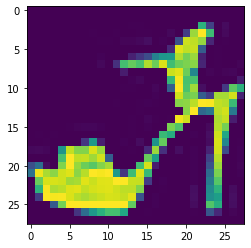

In [ ]:
#Imprimimos el tamaño del conjunto de entrenamiento 
print(f"x_train shape:{X_train.shape} y_train shape:{y_train.shape} \n")

#Imprimimos el tamaño del conjunto de test 
print(f"x_train shape:{X_test.shape} y_train shape:{y_test.shape} \n")

# Definimos las etiquetas del conjunto
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

# Escogemos un índice para visualizar ejemplo, podemos escoger 
# entre 0 and 59,999
index_example = 9

# y_train contiene las etiquetas, desde 0 a 9
label_index = y_train[index_example]

# Mostramos la etiqueta
print ("y = " + str(label_index) + " - categoría: " +(fashion_mnist_labels[label_index]))
# # Show one of the images from the training dataset
plt.imshow(X_train[index_example])

In [ ]:
#Dividir los datos en entrenamiento/validacio/test

(X_train, X_val) = X_train[5000:], X_train[:5000]
(y_train, y_val) = y_train[5000:], y_train[:5000]


In [ ]:
def preprocessing(x,y):
  #dividimos cada pixel por su máximo valor posible
  x = tf.cast(x, tf.float32) / 255.0
  # cada etiqueta la convertimos en tipo entero (van entre 0 y 9)
  y = tf.cast(y, tf.int32)

  return x, y

def create_dataset(xs, ys, n_classes=10):
  
  # codificamos la la etiqueta con one hot encoding, asi tendremos una
  # neurona de salida por cada clase.
  ys = tf.one_hot(ys, depth=n_classes)

  # con from_tensor_slices conbinamos diferentes elementos en un dataset
  # (features and labels), luego ordenamos aleatoriamente en creamos batch 
  # (grupos) de 128 imagenes, que será el tamaño sobre el cual
  # calcularemos nuestra función de perdida, objeto evitar que sea muy ruidosa
  return tf.data.Dataset.from_tensor_slices((xs, ys)) \
    .map(preprocessing) \
    .shuffle(len(ys)) \
    .batch(128)

In [ ]:
# creamos nuevos conjuntos de validación y entrenamiento aplicando el 
# preprocesamiento.

train_dataset = create_dataset(X_train, y_train)
val_dataset = create_dataset(X_val, y_val)
test_dataset = create_dataset(X_test, y_test)


### Creamos nuestra Red Neuronal(NN) usando keras.

La mayoria de las NN se construyen apilando capas. Nuestra primera NN será de 5 capas.

La primera capa será para transformar (Reshape) nuestra entrada 2D de 28x28 a un vector 1D de 784 elementos (28*28). Luego empleamos capas densas (Dense) que significa que son interconectadas (todas las salidas de 1 con todas las entradas de la capa siguiente). Con el parámetro _units_ establecemos el número de neuronas por capa. El parámetro _activation_ específica la función de activación de cada capa (ReLU, sigmoide, Lineal, etc.). La última capa (output) tendrá 10 neuronas (1 por cada clase) y será de la cual obtendremos nuestras predicciones. Que el modelo sea secuencial, significa que estamos creando una red sin realimentaciones (se verán más adelante) que avanza desde la entrada a la salida.

In [ ]:
model = keras.Sequential([
    #Primera capa
    keras.layers.Reshape(target_shape=(28*28,), input_shape=(28,28)),
    #Segunda capa
    keras.layers.Dense(units=256, activation='relu'),
    #Tercera Capa
    keras.layers.Dense(192, activation='relu'),
    #Cuarta capa
    keras.layers.Dense(units=128, activation='relu'),
    #Capa de salida
    keras.layers.Dense(units=10, activation='softmax')
])

#### Entrenando la Red
Para entrenar la red debemos definir algunos parámetros como, el optimizador que usaremos para el algoritmo de "Back propagation", la función de pérdida a emplear y la métrica con la cual mediremos el desempeño de la red eso se hace con el método compile de nuestro modelo.
Acto seguido deberemos ingresar nuestro conjunto de entrenamiento, la cantidad e epocas a entrenar, la cantidad de pasos por epocas, el conjunto de validación y la cantidad de pasos de validación.

In [ ]:
model.compile(optimizer='adam',
              # el vectos y está en forma de un tensor logits, esto es el 
              # inverso de la función sigmoide a nivel de elementos
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_dataset.repeat(),
    epochs = 10,
    steps_per_epoch=500,
    validation_data=val_dataset.repeat(),
    validation_steps = 3
    )

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


500/500 [==============================] - 17s 24ms/step - loss: 0.4972 - accuracy: 0.8231 - val_loss: 0.4089 - val_accuracy: 0.8411
Epoch 2/10
500/500 [==============================] - 7s 15ms/step - loss: 0.3600 - accuracy: 0.8663 - val_loss: 0.2948 - val_accuracy: 0.8958
Epoch 3/10
500/500 [==============================] - 6s 12ms/step - loss: 0.3191 - accuracy: 0.8817 - val_loss: 0.3738 - val_accuracy: 0.8490
Epoch 4/10
500/500 [==============================] - 6s 12ms/step - loss: 0.2975 - accuracy: 0.8891 - val_loss: 0.3244 - val_accuracy: 0.8854
Epoch 5/10
500/500 [==============================] - 6s 13ms/step - loss: 0.2733 - accuracy: 0.8981 - val_loss: 0.2847 - val_accuracy: 0.8802
Epoch 6/10
500/500 [==============================] - 6s 12ms/step - loss: 0.2580 - accuracy: 0.9026 - val_loss: 0.2426 - val_accuracy: 0.9323
Epoch 7/10
500/500 [==============================] - 8s 17ms/step - loss: 0.2477 - accuracy: 0.9076 - val_loss: 0.2643 - val_accuracy: 0.9036
Epoch 8/1

In [ ]:
# Evaluamos el modelo en el conjunto de test
score = model.evaluate(test_dataset, verbose=0)

# Test accuracy
print(f'Test accuracy: {score[1]}')

Test accuracy: 0.8809999823570251


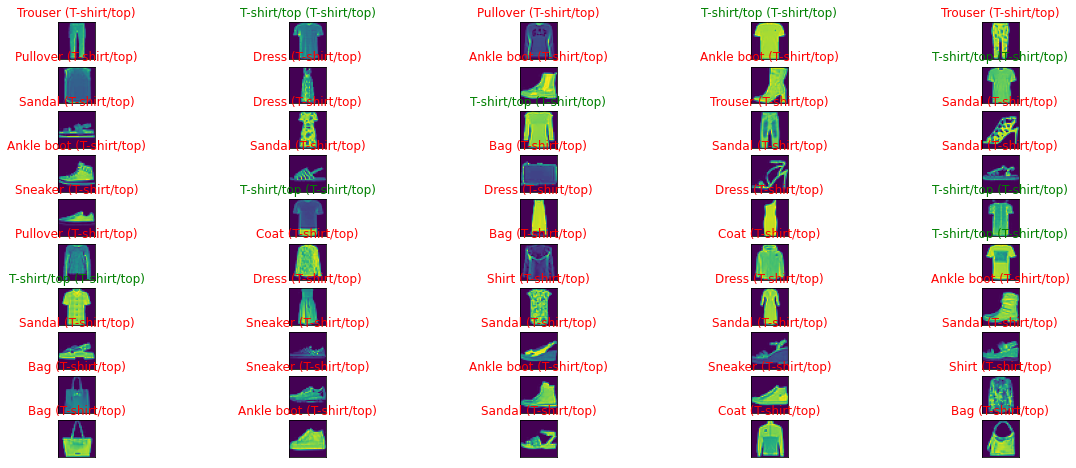

In [ ]:
# Visualizar la predicció
import numpy as np

y_pred = model.predict(X_test)

# Graficar un muestreo aleatorio de imágenes con su preddición y valor de
# verdad

figure = plt.figure(figsize=(20,8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=50, replace=False)):
  ax = figure.add_subplot(10, 5, i+1, xticks=[], yticks=[])
  #Mostrar imágenes
  ax.imshow(np.squeeze(X_test[index]))
  predict_index = np.argmax(y_pred[index])
  true_index = np.argmax(y_test[index])

  ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index],
                                 fashion_mnist_labels[true_index]),
                                 color=('green' if predict_index == true_index else 'red'))
  
  

## Hemos entrenado un clasificador con NN con un accuracy del 88%